### Scandinavian Airlines Customer Satisfaction Reviews

Customer satisfaction should be a top priority for all successful businesses, and the aviation industry is no exception. 

This project aims to analyze data collected from airline reviews to build a predictive model that forecasts whether a passenger will recommend the airline and choose to fly with it again. A satisfied passenger is far more likely to become a repeat customer, which underscores the importance of understanding and improving their experience.

By accurately predicting which passengers are likely to be dissatisfied, the underlying causes of their dissatisfaction can be identified. This enables the airline to make targeted improvements, ultimately enhancing overall customer satisfaction and loyalty.

This is a comprehensive data science end to end project that encompasses the entire process from start to finish. It begins with web scraping passenger reviews from [skytrax](https://www.airlinequality.com/review-pages/a-z-airline-reviews/), followed by cleaning and exploring the dataset. The next steps involve analyzing and visualizing the data to uncover key insights, and finally, building predictive models to forecast future trends and outcomes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For metrics and helpful functions
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,GridSearchCV,RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [39]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
sas_df = pd.read_csv('SAS_Scandinavian.csv')

In [3]:
sas_df.head()

,status,aircraft,travel_type,travel_class,route,date,seating_comfort,staff_service,food_quality,entertainment,wifi,ground_service,value_for_money,recommended,overall_rating,review
0,✅ Trip Verified,NaN,Family Leisure,Economy Class,Copenhagen to Geneva,August 2024,3.0,1.0,2.0,1.0,1.0,1.0,1,no,1.0,I cannot under any circumstances recommend SA...
1,✅ Trip Verified,A320,Couple Leisure,Premium Economy,London Heathrow to Kiruna via Stockholm,June 2024,2.0,5.0,3.0,1.0,1.0,1.0,2,no,4.0,Patchy and mainly underwhelming is the best...
2,✅ Trip Verified,Embraer,Solo Leisure,Business Class,Paris to Stockholm,July 2024,1.0,3.0,2.0,NaN,1.0,1.0,1,no,1.0,"Overall, I paid a premium price for a third ..."
3,✅ Trip Verified,NaN,Family Leisure,Economy Class,Helsinki to Stockholm,June 2024,1.0,1.0,1.0,1.0,1.0,1.0,1,no,1.0,Absolutely useless - my bag was slightly over...
4,Not Verified,NaN,Family Leisure,Economy Class,Washington to Athens,May 2024,1.0,1.0,1.0,1.0,NaN,1.0,1,no,1.0,What an absolute nightmare to travel with S...


In [4]:
sas_df.shape

(910, 16)

In [5]:
sas_df.isna().sum()

status             386
aircraft           613
travel_type        279
travel_class         0
route              282
date               281
seating_comfort     41
staff_service       41
food_quality       152
entertainment      306
wifi               639
ground_service     308
value_for_money      0
recommended          0
overall_rating      24
review               0
dtype: int64

In [7]:
# change date column datatype to datetime
sas_df['date']=pd.to_datetime(sas_df['date'])

In [8]:
# create "year" and "month" columns

sas_df['year']=pd.to_datetime(sas_df['date']).dt.year
sas_df['month']=pd.to_datetime(sas_df['date']).dt.month

In [9]:
#Since most of the records before the year 2016 were null, let's remove them
len(sas_df[sas_df['year'] >=2016])

566

In [11]:
df=sas_df[['travel_type', 'travel_class', 'route', 'date',
       'seating_comfort', 'staff_service', 'food_quality', 'entertainment',
        'ground_service', 'value_for_money', 'recommended',
       'overall_rating', 'review', 'year', 'month']]

In [13]:
# Since the missing information is for those features which were ordered categorical data, missing records were filled with the most frequent value
cols_to_fill=['seating_comfort', 'staff_service', 'food_quality', 'entertainment','ground_service']
# Fill missing values with the mode for each specified column
for column in cols_to_fill:
    mode_value = df[column].mode()[0]  # Calculate the mode of the column
    df[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode

# Check if the missing values have been filled
print(df[cols_to_fill].isnull().sum())

seating_comfort    0
staff_service      0
food_quality       0
entertainment      0
ground_service     0
dtype: int64


In [16]:
#There are still missing information on the other columns, in this case we drop them
df.dropna(subset=['travel_type','date','route','overall_rating','year','month'],inplace = True)


In [18]:
df.isna().sum()

travel_type        0
travel_class       0
route              0
date               0
seating_comfort    0
staff_service      0
food_quality       0
entertainment      0
ground_service     0
value_for_money    0
recommended        0
overall_rating     0
review             0
year               0
month              0
dtype: int64

In [19]:
df=df.reset_index()

### Exploratory Data Analysis

create "sentiment" column from "review" column and see how many of those reviews were positive,negative or neutral

In [21]:
analyzer=SentimentIntensityAnalyzer()

scores=[]

for i in range(len(df['review'])):
    score=analyzer.polarity_scores(df['review'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i >=0.5:
        sentiment.append('Positive')
    elif i <=(-0.5):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['sentiment']=pd.Series(np.array(sentiment))

In [22]:
tab=df.groupby('sentiment')['review'].count().reset_index().sort_values('sentiment',ascending=False)
tab.style.background_gradient(cmap='Blues')

,sentiment,review
2,Positive,227
1,Neutral,124
0,Negative,275


### Visualization

Now let's examine variables that we are interested in, and create plots to visualize relationships between variables.

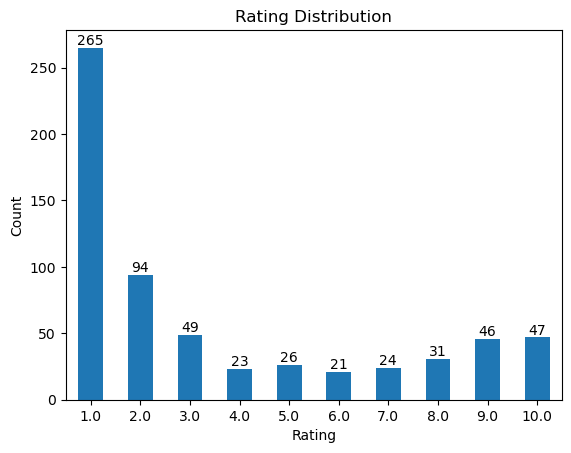

In [23]:
# distribution plot for 'overall rating' column

rating_counts = df['overall_rating'].value_counts().sort_index()
rating_counts.plot(kind='bar')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')

# Show labels on the bars
for index, value in enumerate(rating_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=0)
# Now, display the plot
plt.show()

In [27]:
df['month_year'] = df['date'].dt.to_period('M')


In [28]:
#Create a column called 'Season' from the 'month' column
df['Season'] = df['month_year'].dt.month % 12 // 3 + 1  

# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Season'].map(season_map)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            626 non-null    int64         
 1   travel_type      626 non-null    object        
 2   travel_class     626 non-null    object        
 3   route            626 non-null    object        
 4   date             626 non-null    datetime64[ns]
 5   seating_comfort  626 non-null    float64       
 6   staff_service    626 non-null    float64       
 7   food_quality     626 non-null    float64       
 8   entertainment    626 non-null    float64       
 9   ground_service   626 non-null    float64       
 10  value_for_money  626 non-null    int64         
 11  recommended      626 non-null    object        
 12  overall_rating   626 non-null    float64       
 13  review           626 non-null    object        
 14  year             626 non-null    float64  

Monthly Passenger Reviews 

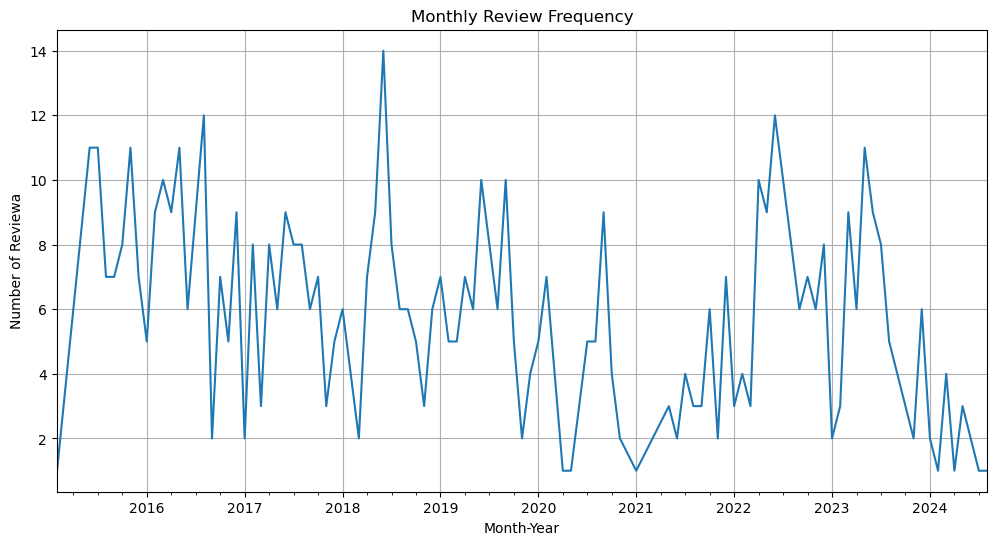

In [31]:
# Group by month_year and count the number of occurrences
monthly_review_frequency = df.groupby('month_year').size()

# Plot the monthly travel frequency
plt.figure(figsize=(12, 6))
monthly_review_frequency.plot()
plt.title('Monthly Review Frequency')
plt.xlabel('Month-Year')
plt.ylabel('Number of Reviewa')
plt.grid(True)
plt.show()

Yearly Passenger Reviews

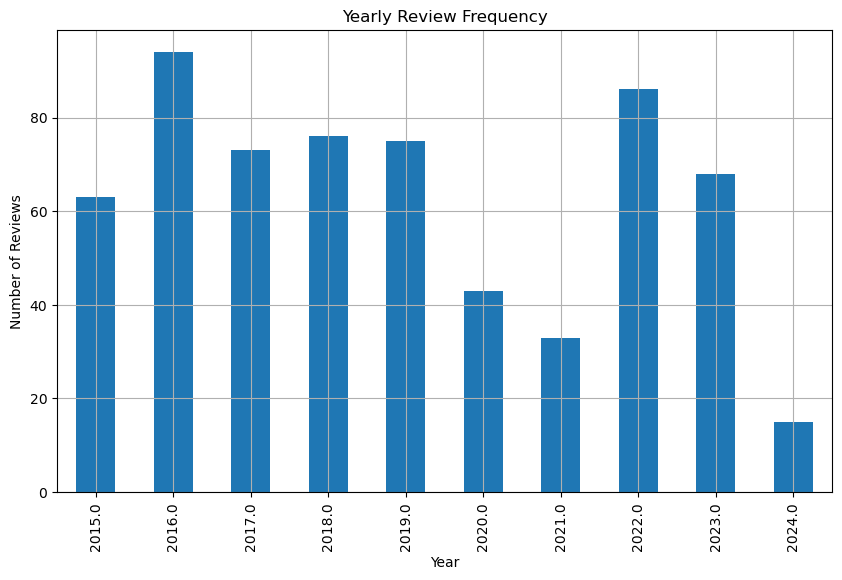

In [32]:
# Group by Year and count the number of occurrences
yearly_review_frequency = df.groupby('year').size()

# Plot the yearly travel frequency
plt.figure(figsize=(10, 6))
yearly_review_frequency.plot(kind='bar')
plt.title('Yearly Review Frequency')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

Monthly Passenger Satisfaction

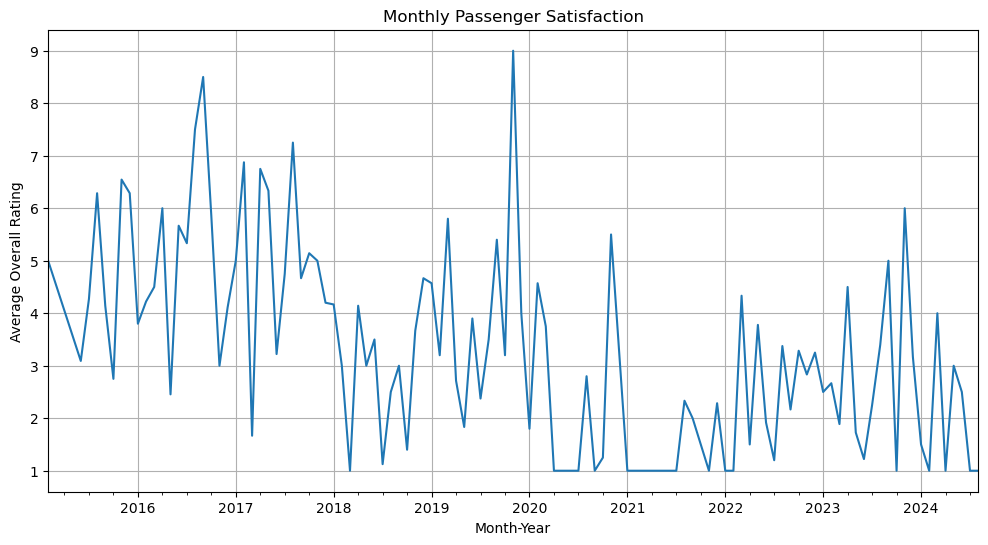

In [33]:
# Calculate the mean overall_rating for each month
monthly_satisfaction = df.groupby('month_year')['overall_rating'].mean()

# Plot the monthly satisfaction trend
plt.figure(figsize=(12, 6))
monthly_satisfaction.plot()
plt.title('Monthly Passenger Satisfaction')
plt.xlabel('Month-Year')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

Yearly Average Passenger Satisfaction

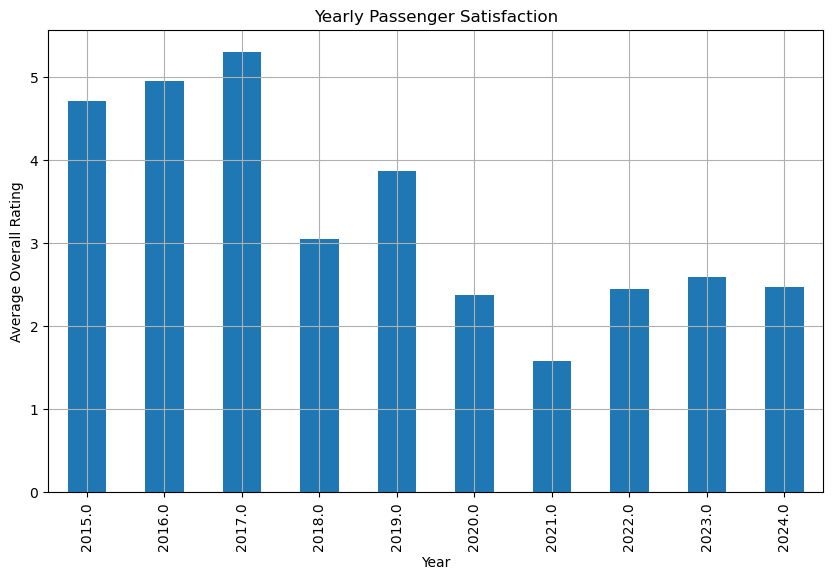

In [34]:
# Calculate the mean overall_rating for each year
yearly_satisfaction = df.groupby('year')['overall_rating'].mean()

# Plot the yearly satisfaction trend
plt.figure(figsize=(10, 6))
yearly_satisfaction.plot(kind='bar')
plt.title('Yearly Passenger Satisfaction')
plt.xlabel('Year')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

Monthly Rating Consistency

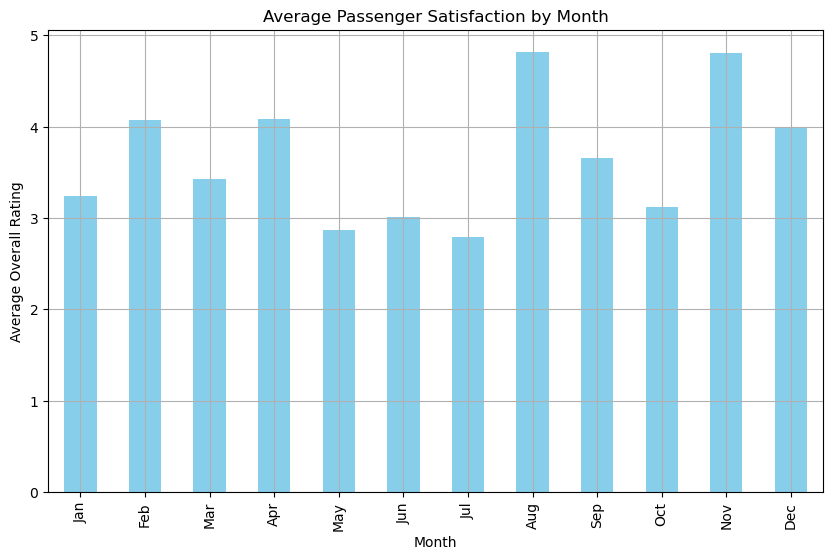

In [35]:
# Calculate the average rating for each month
monthly_avg_rating = df.groupby('month')['overall_rating'].mean()

# Plot the average rating for each month
plt.figure(figsize=(10, 6))
monthly_avg_rating.plot(kind='bar', color='skyblue')
plt.title('Average Passenger Satisfaction by Month')
plt.xlabel('Month')
plt.ylabel('Average Overall Rating')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

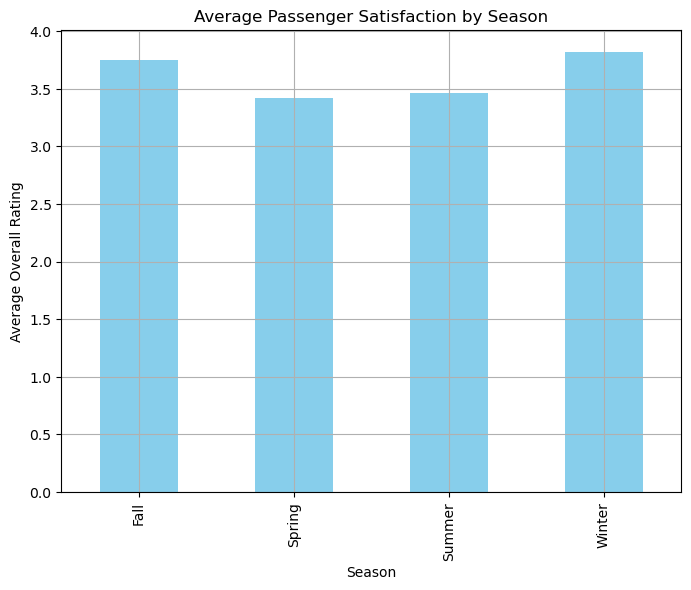

In [36]:
#Seasonal average consistency
seasonal_avg_rating = df.groupby('Season')['overall_rating'].mean()

# Plot the average rating for each season
plt.figure(figsize=(8, 6))
seasonal_avg_rating.plot(kind='bar', color='skyblue')
plt.title('Average Passenger Satisfaction by Season')
plt.xlabel('Season')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

#### Advanced Analysis: Hypothesis Testing

Let's further conduct statistical test ANOVA to see if the differences in ratings across months or seasons are statistically significant.

In [37]:
from scipy.stats import f_oneway

# ANOVA test across months
anova_month = f_oneway(*[df[df['month'] == month]['overall_rating'].dropna() for month in range(1, 13)])
print(f'ANOVA Test across Months: F-statistic={anova_month.statistic}, p-value={anova_month.pvalue}')

ANOVA Test across Months: F-statistic=2.7001938962210086, p-value=0.002100072822755568


p-value = 0.0021: Since the p-value is much less than the threshold 0.05, it is possible to reject the null hypothesis. This means that there is statistically significant evidence to suggest that the average passenger satisfaction ratings are not equal across all months. In other words, the differences in ratings between some months are statistically significant and not due to random chance.

This could suggest that certain months have consistently higher or lower satisfaction, which could be due to various factors like peak travel periods, seasonal weather effects, or changes in service quality.

In order to see which specific months of the year differ from each other, Tukey's HSD test is performed 

In [41]:
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['overall_rating'], groups=df['month'], alpha=0.05)
# Convert the results to a DataFrame for easy filtering
tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Filter the results where reject=True
significant_results = tukey_results[tukey_results['reject'] == True]
# Display the significant results
print(significant_results)

    group1  group2  meandiff   p-adj   lower   upper  reject
40     5.0     8.0    1.9553  0.0340  0.0709  3.8397    True
46     6.0     8.0    1.8063  0.0429  0.0270  3.5856    True
51     7.0     8.0    2.0280  0.0123  0.2322  3.8239    True


There were significant differences in average rating between May, June, July to August.

##### Impact of Travel Class on Satisfaction

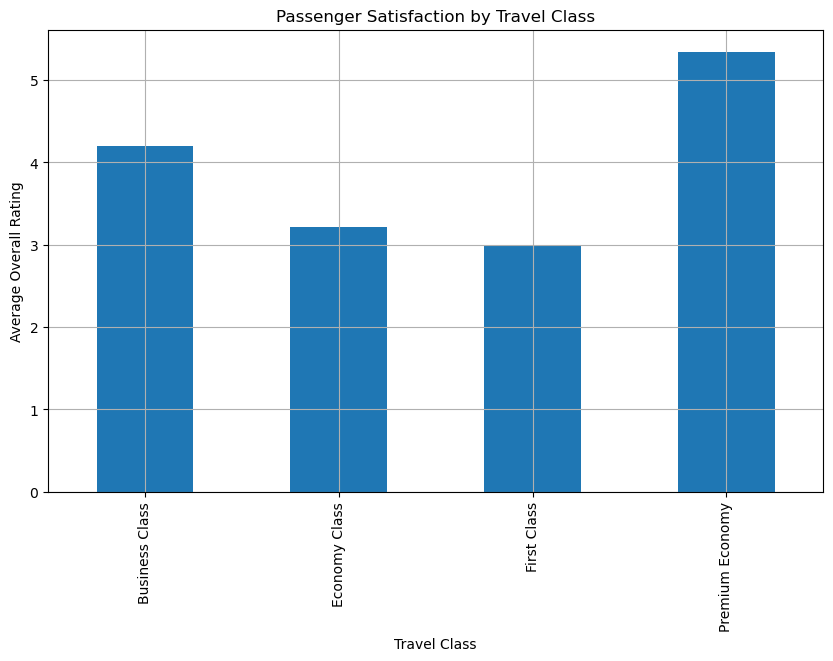

In [42]:
# Calculate the mean overall_rating for each year
class_satisfaction = df.groupby('travel_class')['overall_rating'].mean()

# Plot the yearly satisfaction trend
plt.figure(figsize=(10, 6))
class_satisfaction.plot(kind='bar')
plt.title('Passenger Satisfaction by Travel Class')
plt.xlabel('Travel Class')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Perform a one-way ANOVA test
anova_model = ols('overall_rating ~ C(travel_class)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

# Print the ANOVA table
print(anova_table)

                      sum_sq     df         F    PR(>F)
C(travel_class)   285.088755    3.0  9.715032  0.000003
Residual         6084.221149  622.0       NaN       NaN


Which specific travel classes were significantly different?

In [46]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=df['overall_rating'], groups=df['travel_class'], alpha=0.05)

# Display the Tukey HSD result
print(tukey_result.summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1          group2     meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------
Business Class   Economy Class  -0.9872 0.0148 -1.8344  -0.14   True
Business Class     First Class  -1.2035 0.9493 -6.9506 4.5435  False
Business Class Premium Economy   1.1413 0.1089 -0.1601 2.4426  False
 Economy Class     First Class  -0.2163 0.9997 -5.9258 5.4931  False
 Economy Class Premium Economy   2.1285    0.0  1.0049 3.2521   True
   First Class Premium Economy   2.3448 0.7245 -3.4494 8.1391  False
--------------------------------------------------------------------


There is a statistically significant difference in ratings between Economy and Business Classes as well as Economy and Premium Economy Classes

##### Route

In [56]:
df.route.head()

0                       Copenhagen to Geneva
1    London Heathrow to Kiruna via Stockholm
2                         Paris to Stockholm
3                      Helsinki to Stockholm
4                       Washington to Athens
Name: route, dtype: object

In [48]:
# Split the route column into 'From' and 'To' based on the word 'to'
df[['From', 'To']] = df['route'].str.split(' to ', expand=True)

# Further split the 'To' column to remove any additional text after the destination (like 'via')
df['To'] = df['To'].str.split(' via ').str[0]

In [58]:
df.groupby(['From'])['overall_rating'].mean().sort_values(ascending=False)

From
KEF          10.0
Palanga      10.0
Vienna       10.0
Olbia        10.0
Shanghai     10.0
             ... 
OTP           1.0
Orlando       1.0
Paris CDG     1.0
Reykavik      1.0
Zürich        1.0
Name: overall_rating, Length: 155, dtype: float64

#### Check for Possible duplicates

In [59]:
len(df[df.duplicated()])

0

There were no duplicates in the dataset.

In [60]:
# Before preprocessing the data, save the resulting dataset as a csv for further visualization in Tableau before 
df.to_csv('sas_vis.csv',index = False)

#### Data Pre-Processing

Now it is time for data pre-processing before building a machine learning model. Most machine learning algorithms can not work with categorical data. We need to transform the categorical columns in the dataset to numeric data.

In [61]:
df_ml= df[['travel_type', 'travel_class', 
       'seating_comfort', 'staff_service', 'food_quality', 'entertainment',
       'ground_service', 'value_for_money', 'recommended', 'overall_rating',
       'month', 'Season']]

In [63]:
# select the categorical columns
cat_cols = ['travel_type','travel_class','recommended','Season']
# Importing the LabelEncoder class from scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Creating an instance of the LabelEncoder
label_encoding = LabelEncoder()

# Looping through each categorical column and applying label encoding to convert them to numeric values
for category in cat_cols:
    df_ml[category] = label_encoding.fit_transform(df_ml[category])

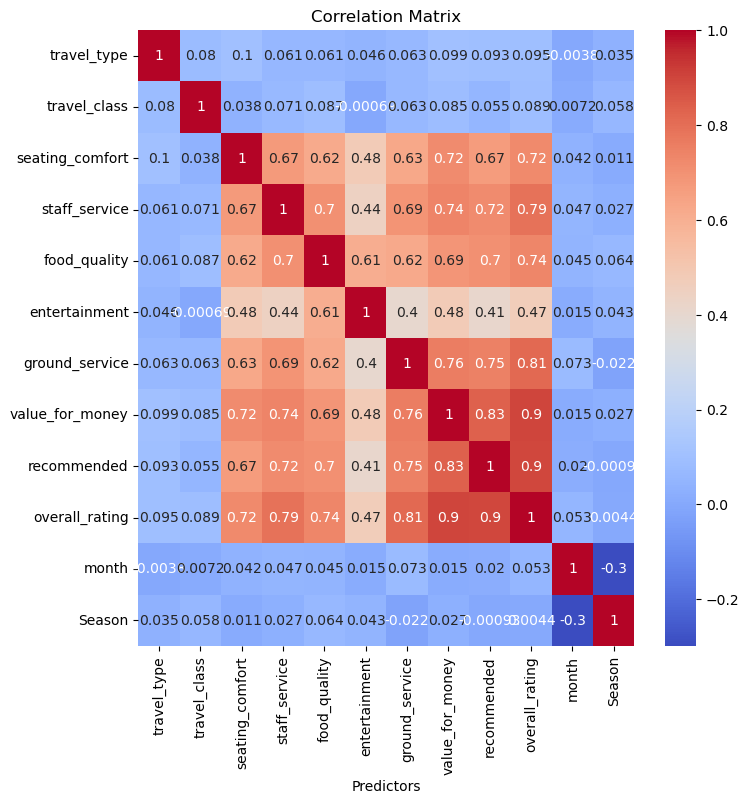

In [64]:
# Create a correlation matrix to analyze predictor correlations
corrMatrix = df_ml.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xlabel('Predictors')
plt.show()

There were high multi colinearity among some of the predictors. So these columns need to be removed.

In [65]:
df_ml = df_ml.drop(columns = ['overall_rating','value_for_money'] , axis=1)

In [66]:
#check the distribution of the target variable
df_ml.recommended.value_counts(normalize=True)

recommended
0    0.715655
1    0.284345
Name: proportion, dtype: float64

In [67]:
df_ml.columns

Index(['travel_type', 'travel_class', 'seating_comfort', 'staff_service',
       'food_quality', 'entertainment', 'ground_service', 'recommended',
       'month', 'Season'],
      dtype='object')

### Model Building

The goal of the project is to build a model that predicts whether passengers would recommend Scandinavian Airlines in the future based on a set of factors.

This classification problem can be best addressed using logistic regression model or tree based models such as random forest, decision tree or XGBOOST models.

No need to standardizse the dataset as all of the features are more or less on the same .

In [70]:
X = df_ml.drop('recommended',axis=1)
y = df_ml['recommended']

In [71]:
df_ml.recommended.value_counts(normalize=True)

recommended
0    0.715655
1    0.284345
Name: proportion, dtype: float64

AUC-ROC is most suitable metric to compare the different models, sicnce the dataset is imbalanced as more passengers don't recommend the airline than those who do.
AUC-ROC also best captures the model's performance across all possible classification thresholds than other metrics.

In [72]:
def compare_auc_roc(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # Initialize the models
    models= {'Logistic Regression': LogisticRegression(max_iter=500),
         'Decison Tree': DecisionTreeClassifier(max_depth=6,random_state=1),
         'Random Forest': RandomForestClassifier(max_depth=6, n_estimators=500, random_state=1),
         'XGBoost': XGBClassifier(max_depth=6,n_estimators=500,random_state=1)
}
    # Dictionary to store the AUC-ROC values
    auc_roc_scores = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get the probability for the positive class
        auc_roc = roc_auc_score(y_test, y_pred_prob)
        auc_roc_scores[name] = auc_roc
        print(f'{name} AUC-ROC: {auc_roc:.4f}')
    # Convert the results to a DataFrame for easy comparison
    auc_roc_df = pd.DataFrame.from_dict(auc_roc_scores, orient='index', columns=['AUC-ROC']).sort_values(by='AUC-ROC', ascending=False)

    return auc_roc_df

In [73]:
# Compare AUC-ROC values
auc_roc_comparison = compare_auc_roc(X, y)
print(auc_roc_comparison)

Logistic Regression AUC-ROC: 0.9605
Decison Tree AUC-ROC: 0.8855
Random Forest AUC-ROC: 0.9663
XGBoost AUC-ROC: 0.9417
                      AUC-ROC
Random Forest        0.966292
Logistic Regression  0.960522
XGBoost              0.941695
Decison Tree         0.885515


In [76]:
def plot_confusion_matrices(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Initialize the models
    models= {'Logistic Regression': LogisticRegression(max_iter=500),
         'Decison Tree': DecisionTreeClassifier(max_depth=6,random_state=1),
         'Random Forest': RandomForestClassifier(max_depth=6, n_estimators=500, random_state=1),
         'XGBoost': XGBClassifier(max_depth=6,n_estimators=500,random_state=1)
    }
    
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Train, predict, and plot confusion matrices for each model
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot the confusion matrix 
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


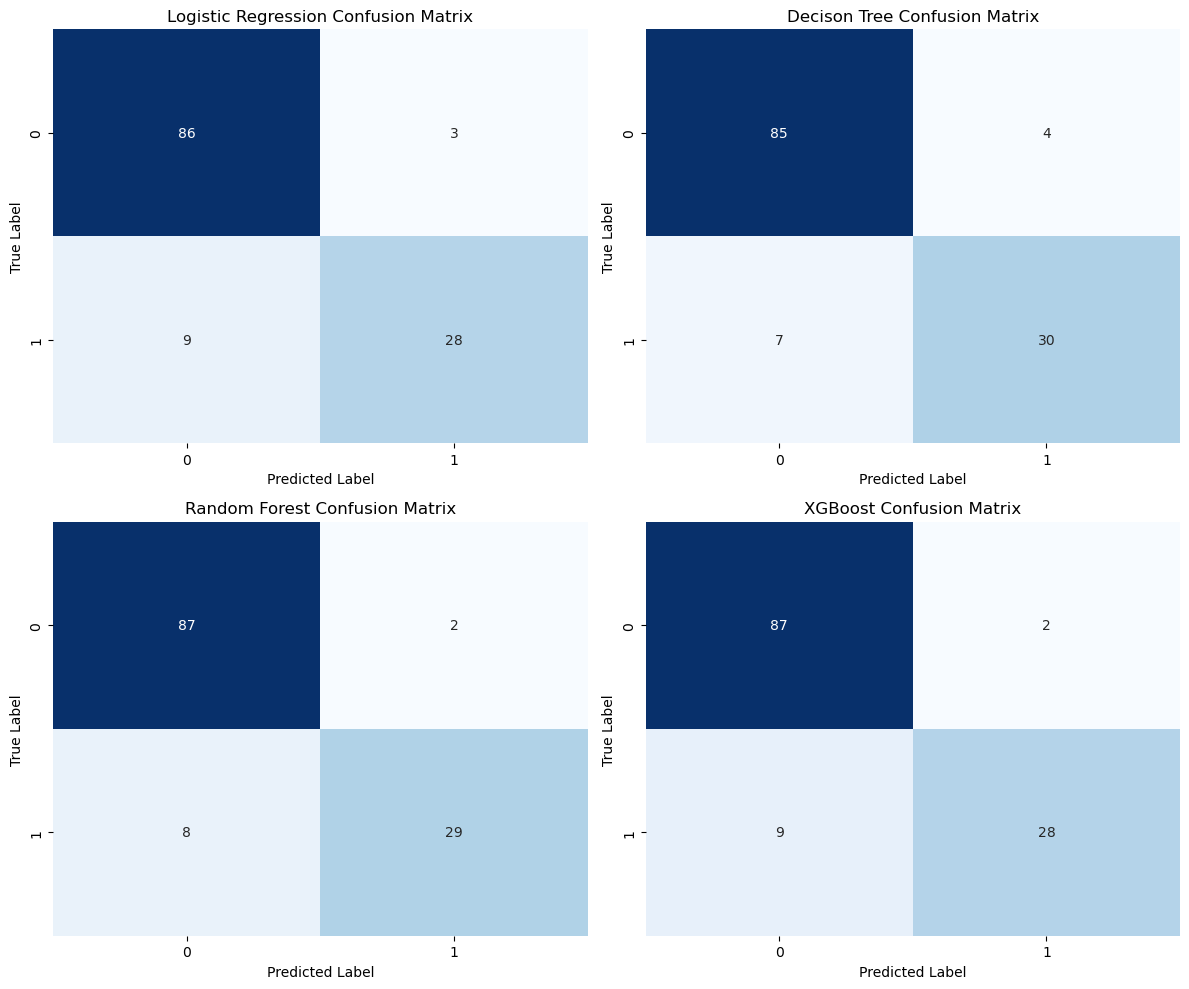

In [77]:
plot_confusion_matrices(X, y)


##### Feature Importance

The random forest model performed better and had a higher AUC-ROC score and is the champion model for prediction.

Which Features contribute the most to a passenger recommending Scandinavian Airlines in the futre?

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
RF=RandomForestClassifier(max_depth=6, n_estimators=500, random_state=1).fit(X_train,y_train)

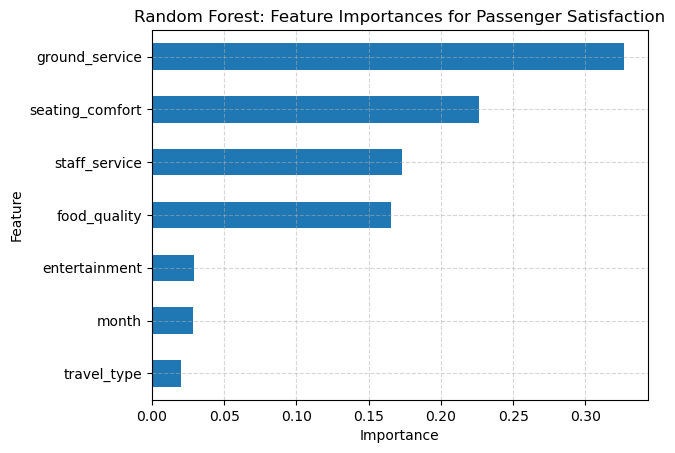

In [80]:
# Get feature importances
feat_impt = RF.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(RF.feature_importances_, -7)[-7:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]
# create a dataframe and sort it based on importance
y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt}).sort_values("Importance")

# Use a horizontal bar chart for better readability
y_df.plot.barh(x="Feature", y="Importance", title="Random Forest: Feature Importances for Passenger Satisfaction", legend=False)

# It's a good practice to add labels to both axes for clarity.
plt.xlabel("Importance")
plt.ylabel("Feature")

#add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Conclusion

Based on the Random Forest classification model, the most important features influencing whether passengers recommend Scandinavian Airlines are:

- Ground Services
- Seating Comfort
- Staff Service
- Food Quality
- Entertainment

These features play a significant role in passengers' likelihood of recommending the airline. The importance of these features indicates that improvements in these areas could significantly enhance overall passenger satisfaction and recommendation rates.

#### Recommendations

- Ground service is the most influential factor, prioritize improvements in areas such as check-in processes, baggage handling, and airport assistance. Ensuring a smooth and pleasant experience before and after the flight can significantly impact passengers' overall satisfaction.
- Seating comfort is crucial for passengers, especially on long-haul flights. Consider upgrading seats, offering more legroom, or providing additional amenities like pillows and blankets.
- Focus on customer service training to ensure that staff are responsive, and efficient in addressing passenger needs.
- Passengers place a high value on the quality of food served during the flight. Improving meal options, catering to dietary preferences, and enhancing the overall dining experience can positively influence passengers’ recommendations.
- In-flight entertainment plays a significant role in passenger satisfaction. Consider updating the content library regularly and offering a variety of entertainment options.